In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys, os

path2add = os.path.normpath(os.path.abspath('..'))
if path2add not in sys.path: sys.path.append(path2add)

import torch
from torch_geometric.data import Data
from dataloader import GraphDataset, GraphTextDataset, TextDataset, GraphTextInMDataset, AllGraphDataset, AugmentGraphDataset, AugmentGraphTextDataset
from augment import RWSample, UniformSample
import networkx as nx

from transformers import AutoTokenizer
import numpy as np

In [3]:
tokenizer = AutoTokenizer.from_pretrained('nlpie/distil-biobert')

In [4]:
transforms = [RWSample(), UniformSample()]

def transform_augment(sample):
    tmp = sample.clone()
    if tmp.x.shape[0] > 6:
        choice = np.random.randint(2)
        transform = transforms[choice]
        tmp = transform(tmp)

    data = Data(
        x = sample.x,
        edge_index = sample.edge_index,

        x_augment = tmp.x,
        edge_index_augment = tmp.edge_index,

        input_ids = sample.input_ids,
        attention_mask = sample.attention_mask,

        description = sample.description,
    )
    return data

In [5]:
gt = np.load("../data/token_embedding_dict.npy", allow_pickle=True)[()]
train_dataset = AugmentGraphTextDataset(
    root="../data/", gt=gt, split="train", tokenizer=tokenizer, model_name='nlpie/distil-biobert', transform=transform_augment
)

In [6]:
len(train_dataset)

26408

In [15]:
sample = train_dataset[45]
sample.edge_index_augment, sample.edge_index

(tensor([[0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 6, 7, 7, 8, 5, 0, 8, 3],
         [1, 0, 2, 1, 3, 2, 4, 3, 5, 4, 7, 6, 8, 7, 0, 5, 3, 8]]),
 tensor([[0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 4, 6, 6, 7, 7, 8, 8, 9, 5, 0, 9, 3],
         [1, 0, 2, 1, 3, 2, 4, 3, 5, 4, 6, 4, 7, 6, 8, 7, 9, 8, 0, 5, 3, 9]]))

Data(x=[20, 300], edge_index=[2, 38], x_augment=[18, 300], edge_index_augment=[2, 34], input_ids=[2, 256], attention_mask=[2, 256], description=[2])


(['Petroselaidate is an unsaturated fatty acid anion resulting from the deprotonation of the carboxy group of petroselaidic acid. The major species at pH 7.3',
  'It is a long-chain fatty acid anion and an unsaturated fatty acid anion. It is a conjugate base of a petroselaidic acid.'],
 ['Petroselaidate is an unsaturated fatty acid anion resulting from the deprotonation of the carboxy group of petroselaidic acid. The major species at pH 7. 3',
  'It is a long - chain fatty acid anion and an unsaturated fatty acid anion. It is a conjugate base of a petroselaidic acid.'])

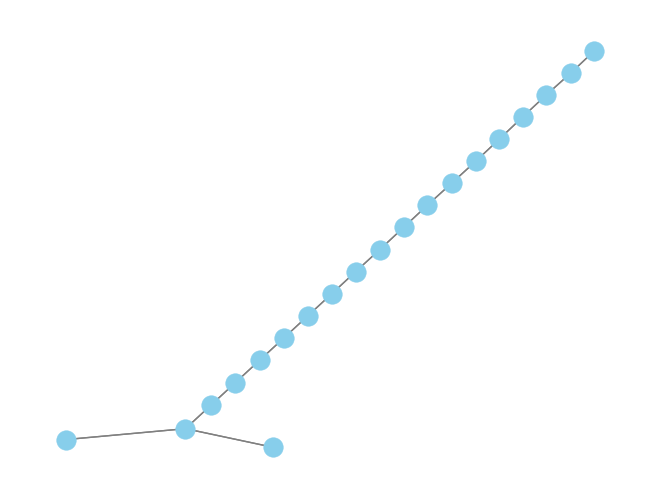

In [7]:
sample = train_dataset[9879]
print(sample)

edges = sample.edge_index
G = nx.DiGraph()
for i in range(len(edges[0])):
    G.add_edge(int(edges[0][i]), int(edges[1][i]))
pos = nx.kamada_kawai_layout(G)
nx.draw(G, pos, with_labels=False, font_size=8, node_color='skyblue', node_size=200, edge_color='gray', linewidths=0.3, arrows=False)



sample.description, tokenizer.batch_decode(sample.input_ids, skip_special_tokens=True)

In [8]:
# tds = GraphTextInMDataset(
#     root="../data/", gt=gt, split="train", tokenizer=tokenizer, model_name='nlpie/distil-biobert'
# )

In [9]:
# tds[45]

Data(x=[10, 300], edge_index=[2, 22], input_ids=[1, 256], attention_mask=[1, 256])

In [8]:
from torch_geometric.loader import DataLoader

batch_size = 21
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
)

In [9]:
batch = next(iter(train_loader))
batch

DataBatch(x=[563, 300], edge_index=[2, 1184], x_augment=[476, 300], edge_index_augment=[2, 924], input_ids=[42, 256], attention_mask=[42, 256], description=[21], batch=[563], ptr=[22])

In [10]:
tokenizer.batch_decode(batch.input_ids, skip_special_tokens=True)

["Furano [ 2'', 3'' : 6, 7 ] aurone is a member of the class of aurones that is aurone with a furan ring fused across positions C - 6, and - 7",
 'It has a role as a metabolite. It is a member of aurones and a cyclic ketone. It derives from an aurone.',
 "Rubianol - e 3 - O - ( 6'- O - acetyl ) - beta - D - glucopyranoside is a triterpenoid saponin with an arborinane - type terpenoid as the aglycone. It has been isolated from the roots of Rubia yunnanensis. It has a role as a plant metabolite",
 'It is a pentacyclic triterpenoid, an acetate ester, a diol, a triterpenoid saponin, a monosaccharide derivative and a beta - D - glucoside.',
 '5beta - cholestane - 3alpha, 7alpha, 26 - triol is a 3alpha - hydroxy steroid, a 7alpha - hydroxy steroid and a 26 - hydroxy steroid. It has a role as a bile acid metabolite, a human metabolite and a mouse metabolite',
 'It derives from a hydride of a 5beta - cholestane.',
 'Clenbuterol ( 1 + ) is the ammonium ion that is the conjugate acid of clenbute